In [1]:
# Sri Lanka Fisheries Trip Cost Prediction Model
# Local Training Script (Non-Colab Version)
# Uses datasets from ../datasetfiles/ directory

import os
import sys

# Set project paths
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in globals() else os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_ROOT, 'datasetfiles')
MODEL_DIR = os.path.join(PROJECT_ROOT, 'model_files')

print(f"📁 Project Root: {PROJECT_ROOT}")
print(f"📊 Data Directory: {DATA_DIR}")
print(f"🤖 Model Directory: {MODEL_DIR}")

# Verify data directory exists
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")

# List available CSV files
csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
print(f"\n✅ Found {len(csv_files)} CSV files in data directory")

📁 Project Root: c:\Users\Piuminda Jayaweera\Desktop\RESEARCH\new\final_year_research
📊 Data Directory: c:\Users\Piuminda Jayaweera\Desktop\RESEARCH\new\final_year_research\datasetfiles
🤖 Model Directory: c:\Users\Piuminda Jayaweera\Desktop\RESEARCH\new\final_year_research\model_files

✅ Found 9 CSV files in data directory


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import glob
import json
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [10]:
# Load Training Data from Local Directory
def load_training_data(data_dir):
    """Load all training CSV files from local datasetfiles directory"""
    print("\n📊 Loading training data from local directory...")
    
    # Find all training files
    train_files = glob.glob(os.path.join(data_dir, "sri_lanka_fisheries_train_*.csv"))
    
    if not train_files:
        raise FileNotFoundError(f"No training files found in {data_dir}")
    
    # Load and concatenate all training data
    train_dfs = []
    for file in sorted(train_files):
        df = pd.read_csv(file)
        train_dfs.append(df)
        print(f"   ✅ Loaded: {os.path.basename(file)} ({len(df):,} rows)")
    
    # Combine all training data
    train_df = pd.concat(train_dfs, ignore_index=True)
    print(f"\n✅ Total training data: {len(train_df):,} rows")
    print(f"   Date range: {train_df['trip_date'].min()} to {train_df['trip_date'].max()}")
    
    return train_df

# Load the data
df_train = load_training_data(DATA_DIR)


📊 Loading training data from local directory...
   ✅ Loaded: sri_lanka_fisheries_train_2022.csv (1,600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2023.csv (1,600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2024.csv (1,600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2025.csv (1,600 rows)

✅ Total training data: 6,400 rows
   Date range: 2022-01-01 to 2025-12-28


In [12]:
# Load Test Data from Local Directory
def load_test_data(data_dir):
    """Load all test CSV files from local datasetfiles directory"""
    print("\n📊 Loading test data from local directory...")
    
    # Find all test files
    test_files = glob.glob(os.path.join(data_dir, "sri_lanka_fisheries_test_*.csv"))
    
    if not test_files:
        print("⚠️ No test files found - will use train/test split from training data")
        return None
    
    # Load and concatenate all test data
    test_dfs = []
    for file in sorted(test_files):
        df = pd.read_csv(file)
        test_dfs.append(df)
        print(f"   ✅ Loaded: {os.path.basename(file)} ({len(df):,} rows)")
    
    # Combine all test data
    test_df = pd.concat(test_dfs, ignore_index=True)
    print(f"\n✅ Total test data: {len(test_df):,} rows")
    
    return test_df

# Load test data
df_test = load_test_data(DATA_DIR)


📊 Loading test data from local directory...
   ✅ Loaded: sri_lanka_fisheries_test_2022.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2023.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2024.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2025.csv (400 rows)

✅ Total test data: 1,600 rows


In [13]:
# Data Overview
print("\n" + "="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"\n📊 Training Dataset Shape: {df_train.shape}")
print(f"   Rows: {df_train.shape[0]:,}")
print(f"   Columns: {df_train.shape[1]}")

if df_test is not None:
    print(f"\n📊 Test Dataset Shape: {df_test.shape}")
    print(f"   Rows: {df_test.shape[0]:,}")
    print(f"   Columns: {df_test.shape[1]}")

print(f"\n📋 Column Names:")
for i, col in enumerate(df_train.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n🔢 Data Types:")
print(df_train.dtypes.value_counts())

print(f"\n💾 Memory Usage:")
print(f"   {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


DATA OVERVIEW

📊 Training Dataset Shape: (6400, 46)
   Rows: 6,400
   Columns: 46

📊 Test Dataset Shape: (1600, 46)
   Rows: 1,600
   Columns: 46

📋 Column Names:
    1. year
    2. trip_id
    3. boat_type
    4. engine_hp
    5. trip_days
    6. month
    7. port_name
    8. departure_lat
    9. departure_lon
   10. fishing_lat
   11. fishing_lon
   12. distance_km
   13. wind_kph
   14. wave_m
   15. safety
   16. diesel_liters
   17. petrol_liters
   18. kerosene_liters
   19. fuel_cost_LKR
   20. crew_cost_LKR
   21. ice_cost_LKR
   22. gear_loss_cost_LKR
   23. total_cost_LKR
   24. gross_revenue_LKR
   25. tax_amount_LKR
   26. net_revenue_LKR
   27. gross_profit_LKR
   28. net_profit_margin
   29. trip_date
   30. fuel_date_used
   31. diesel_price_LKR
   32. petrol_price_LKR
   33. kerosene_price_LKR
   34. catch_Yellowfin_Tuna_kg
   35. revenue_Yellowfin_Tuna_LKR
   36. catch_Skipjack_kg
   37. revenue_Skipjack_LKR
   38. catch_Marlin_kg
   39. revenue_Marlin_LKR
   40. catc

In [14]:
# Display first few rows
print("\n📋 First 5 rows of training data:")
print(df_train.head())

print("\n📊 Basic Statistics:")
print(df_train.describe())


📋 First 5 rows of training data:
   year  trip_id boat_type  engine_hp  trip_days  month       port_name  \
0  2022     1691      NTRB          0          1     11        Beruwala   
1  2022      769      NBSB          0          1      5       Kalpitiya   
2  2022     1821      OFRP         20          2      4        Beruwala   
3  2022      910      OFRP         16          2      1  Kankesanthurai   
4  2022     1568      OFRP         24          2      4      Hambantota   

   departure_lat  departure_lon  fishing_lat  ...  revenue_Skipjack_LKR  \
0         6.0535        80.2209       6.0625  ...                3972.0   
1         8.5560        79.8000       8.5355  ...               16836.0   
2         6.0535        80.2209       6.1580  ...               63012.0   
3         9.6615        80.0104       9.4716  ...               59904.0   
4         5.9549        80.5549       6.0639  ...               52644.0   

   catch_Marlin_kg  revenue_Marlin_LKR  catch_Seer_kg revenue_Se

In [15]:
# Check for Missing Values
print("\n" + "="*60)
print("MISSING VALUES CHECK")
print("="*60)

missing = df_train.isnull().sum()
missing_pct = (missing / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("\n✅ No missing values found!")


MISSING VALUES CHECK
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []

✅ No missing values found!


In [ ]:
# Data Quality Checks
print("\n" + "="*60)
print("DATA QUALITY CHECKS")
print("="*60)

# Check for duplicate rows
duplicates = df_train.duplicated().sum()
print(f"\n🔍 Duplicate rows: {duplicates}")

# Check target variable distribution
print(f"\n🎯 Target Variable (total_cost_LKR) Statistics:")
print(df_train['total_cost_LKR'].describe())

# Check for negative values in cost columns
cost_columns = [col for col in df_train.columns if 'cost' in col or 'revenue' in col or 'profit' in col]
print(f"\n💰 Cost-related columns: {len(cost_columns)}")


DATA QUALITY CHECKS

🔍 Duplicate rows: 0

🎯 Target Variable (total_trip_cost_lkr) Statistics:


KeyError: 'total_trip_cost_lkr'

In [ ]:
# Target Variable Analysis
print("\n" + "="*60)
print("TARGET VARIABLE ANALYSIS")
print("="*60)

target_stats = df_train['total_cost_LKR'].describe()
print(f"\n📊 Total Trip Cost Statistics:")
print(f"   Mean: LKR {target_stats['mean']:,.2f}")
print(f"   Median: LKR {target_stats['50%']:,.2f}")
print(f"   Std Dev: LKR {target_stats['std']:,.2f}")
print(f"   Min: LKR {target_stats['min']:,.2f}")
print(f"   Max: LKR {target_stats['max']:,.2f}")

# Cost breakdown
print(f"\n💰 Cost Components (Mean values):")
print(f"   Fuel Cost: LKR {df_train['fuel_cost_LKR'].mean():,.2f}")
print(f"   Crew Cost: LKR {df_train['crew_cost_LKR'].mean():,.2f}")
print(f"   Ice Cost: LKR {df_train['ice_cost_LKR'].mean():,.2f}")
print(f"   Gear Loss: LKR {df_train['gear_loss_cost_LKR'].mean():,.2f}")


TARGET VARIABLE ANALYSIS


KeyError: 'total_trip_cost_lkr'

In [ ]:
# Visualize Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_train['total_cost_LKR'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Trip Cost (LKR)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Total Trip Cost')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_train['total_cost_LKR'])
axes[1].set_ylabel('Total Trip Cost (LKR)')
axes[1].set_title('Box Plot of Total Trip Cost')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Target variable distribution visualized")

NameError: name 'plt' is not defined

## Feature Engineering and Selection

Now we'll prepare the features for model training by:
1. Identifying important features
2. Encoding categorical variables  
3. Creating new features if needed
4. Scaling numerical features

In [ ]:
# Feature Selection
print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)

# Define target variable
target = 'total_cost_LKR'

# Select input features - using available features from the dataset
input_features = [
    'boat_type',
    'engine_hp',
    'trip_days',
    'distance_km',
    'wind_kph',
    'wave_m',
    'month',
    'port_name',
    'diesel_price_LKR',
    'petrol_price_LKR',
    'kerosene_price_LKR'
]

print(f"\n📊 Selected Features: {len(input_features)}")
for i, feature in enumerate(input_features, 1):
    print(f"   {i}. {feature}")

print(f"\n🎯 Target Variable: {target}")

# Verify all features exist in dataset
missing_features = [f for f in input_features if f not in df_train.columns]
if missing_features:
    print(f"\n⚠️ Warning: Missing features: {missing_features}")
else:
    print(f"\n✅ All features are available in the dataset")


FEATURE SELECTION

✅ Selected 13 input features:


NameError: name 'df_train' is not defined

In [ ]:
# Data Preparation
print("\n" + "="*60)
print("DATA PREPARATION")
print("="*60)

# Create a copy of the dataframe with only needed columns
df_model = df_train[input_features + [target]].copy()

print(f"\n📊 Model dataset shape: {df_model.shape}")
print(f"   Features: {len(input_features)}")
print(f"   Target: {target}")
print(f"   Total samples: {len(df_model):,}")

print(f"\n🔍 Data types:")
print(df_model.dtypes)


DATA PREPARATION


NameError: name 'df_train' is not defined

In [ ]:
# Encode Categorical Variables
print("\n" + "="*60)
print("ENCODING CATEGORICAL VARIABLES")
print("="*60)

# Identify categorical columns
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != target]

print(f"\n📋 Categorical columns found: {len(categorical_cols)}")
for col in categorical_cols:
    unique_count = df_model[col].nunique()
    print(f"   • {col}: {unique_count} unique values")

# Encode categorical variables
label_encoders = {}
df_encoded = df_model.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"   ✅ Encoded: {col}")

print(f"\n✅ Encoding complete. Encoded {len(categorical_cols)} columns")
print(f"📊 Encoded dataset shape: {df_encoded.shape}")

In [ ]:
# Prepare Features and Target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
print(f"\n✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")

In [ ]:
# Split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

✅ Created new features:
   Base cost mean: LKR 257,685
   Components:
     - Fuel:           LKR 211,351
     - Ice:            LKR 8,525
     - Water:          LKR 6,107
     - Basic ops:      LKR 31,703


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Training features scaled: {X_train_scaled.shape}")
print(f"✅ Test features scaled: {X_test_scaled.shape}")
print(f"\n📊 Scaler statistics saved for future predictions")


🔧 Applying same transformations to test data...


In [ ]:
# Convert scaled arrays back to DataFrames for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"✅ Scaled data converted back to DataFrames")
print(f"📊 Feature names preserved: {list(X_train_scaled_df.columns[:5])}...")


PHASE 2: TRAINING STRATEGY


In [ ]:
## Model Training

Train multiple regression models to predict fishing trip costs.


🎯 2.1 Defining Features and Target


In [ ]:
# Initialize Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

print(f"\n📊 Training {len(models)} models...")
print(f"   Training samples: {X_train_scaled.shape[0]:,}")
print(f"   Test samples: {X_test_scaled.shape[0]:,}")
print(f"   Features: {X_train_scaled.shape[1]}")

   Features: 14 base features
   Target: base_cost_LKR
   Training samples: 2,079


In [ ]:
# Train all models and store results
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae
    }
    
    print(f"   ✅ Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"   ✅ Train RMSE: {train_rmse:,.2f} | Test RMSE: {test_rmse:,.2f}")

In [ ]:
# Display Results Summary
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print("\n", results_df.to_string())

In [ ]:
# Find best model based on test R²
best_model_name = max(results.items(), key=lambda x: x[1]['test_r2'])[0]
best_model = trained_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"   Test RMSE: {results[best_model_name]['test_rmse']:,.2f} LKR")
print(f"   Test MAE: {results[best_model_name]['test_mae']:,.2f} LKR")

In [ ]:
# Visualize Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Test R² Comparison
ax1 = axes[0, 0]
test_r2_scores = [results[m]['test_r2'] for m in models.keys()]
bars = ax1.barh(list(models.keys()), test_r2_scores, color='steelblue')
ax1.set_xlabel('R² Score')
ax1.set_title('Test R² Comparison')
ax1.set_xlim([0, 1])
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
             ha='left', va='center', fontsize=9)

# Test RMSE Comparison
ax2 = axes[0, 1]
test_rmse_scores = [results[m]['test_rmse'] for m in models.keys()]
bars = ax2.barh(list(models.keys()), test_rmse_scores, color='coral')
ax2.set_xlabel('RMSE (LKR)')
ax2.set_title('Test RMSE Comparison')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', 
             ha='left', va='center', fontsize=9)

# Train vs Test R² 
ax3 = axes[1, 0]
model_names = list(models.keys())
x = np.arange(len(model_names))
width = 0.35
train_r2 = [results[m]['train_r2'] for m in model_names]
test_r2 = [results[m]['test_r2'] for m in model_names]
ax3.bar(x - width/2, train_r2, width, label='Train R²', color='lightblue')
ax3.bar(x + width/2, test_r2, width, label='Test R²', color='steelblue')
ax3.set_ylabel('R² Score')
ax3.set_title('Train vs Test R²')
ax3.set_xticks(x)
ax3.set_xticklabels(model_names, rotation=45, ha='right')
ax3.legend()
ax3.set_ylim([0, 1])

# Test MAE Comparison
ax4 = axes[1, 1]
test_mae_scores = [results[m]['test_mae'] for m in models.keys()]
bars = ax4.barh(list(models.keys()), test_mae_scores, color='lightcoral')
ax4.set_xlabel('MAE (LKR)')
ax4.set_title('Test MAE Comparison')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2, f'{width:,.0f}', 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


🔍 STEP 2: EXPLORATORY DATA ANALYSIS


In [ ]:
# Save the Best Model and Preprocessing Objects
print("\n" + "="*60)
print("SAVING MODEL AND PREPROCESSING OBJECTS")
print("="*60)

# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the best model
model_filename = os.path.join(MODEL_DIR, f'fishing_cost_model_best_{timestamp}.joblib')
joblib.dump(best_model, model_filename)
print(f"\n✅ Best model saved: {os.path.basename(model_filename)}")

# Save the latest model (overwrite)
latest_model_filename = os.path.join(MODEL_DIR, 'fishing_cost_model_latest.joblib')
joblib.dump(best_model, latest_model_filename)
print(f"✅ Latest model saved: {os.path.basename(latest_model_filename)}")

In [ ]:
# Save preprocessing objects
scaler_filename = os.path.join(MODEL_DIR, 'scaler.joblib')
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {os.path.basename(scaler_filename)}")

encoders_filename = os.path.join(MODEL_DIR, 'label_encoders.joblib')
joblib.dump(label_encoders, encoders_filename)
print(f"✅ Label encoders saved: {os.path.basename(encoders_filename)}")

In [ ]:
# Save feature names and model metadata
metadata = {
    'model_name': best_model_name,
    'feature_names': list(X.columns),
    'target_name': target,
    'categorical_features': list(label_encoders.keys()),
    'test_r2': results[best_model_name]['test_r2'],
    'test_rmse': results[best_model_name]['test_rmse'],
    'test_mae': results[best_model_name]['test_mae'],
    'training_date': datetime.now().isoformat(),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_filename = os.path.join(MODEL_DIR, 'model_metadata.json')
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {os.path.basename(metadata_filename)}")

print(f"\n🎉 All model files saved successfully!")
print(f"📁 Location: {MODEL_DIR}")

   After encoding: 25 features


In [ ]:
## Model Testing

Test the saved model by loading it and making predictions.


📊 2.2 Data Splitting


In [ ]:
# Load the saved model and preprocessing objects
print("\n" + "="*60)
print("TESTING SAVED MODEL")
print("="*60)

loaded_model = joblib.load(latest_model_filename)
loaded_scaler = joblib.load(scaler_filename)
loaded_encoders = joblib.load(encoders_filename)
with open(metadata_filename, 'r') as f:
    loaded_metadata = json.load(f)

print(f"\n✅ Model loaded: {loaded_metadata['model_name']}")
print(f"✅ Test R²: {loaded_metadata['test_r2']:.4f}")
print(f"✅ Test RMSE: {loaded_metadata['test_rmse']:,.2f} LKR")
print(f"✅ Features: {len(loaded_metadata['feature_names'])}")

In [ ]:
# Test prediction with a sample
print("\n📊 Testing with sample data...")

# Get a sample from test set
sample_idx = 0
sample_original = df_test.iloc[sample_idx]

# Prepare sample for prediction
sample_data = {}
for feature in input_features:
    sample_data[feature] = sample_original[feature]

# Create DataFrame
sample_df = pd.DataFrame([sample_data])

# Encode categorical variables
sample_encoded = sample_df.copy()
for col, encoder in loaded_encoders.items():
    if col in sample_encoded.columns:
        sample_encoded[col] = encoder.transform(sample_encoded[col].astype(str))

# Scale features
sample_scaled = loaded_scaler.transform(sample_encoded)

# Make prediction
predicted_cost = loaded_model.predict(sample_scaled)[0]
actual_cost = sample_original['total_cost_LKR']

print(f"\n🎯 Prediction Results:")
print(f"   Boat Type: {sample_original['boat_type']}")
print(f"   Trip Days: {sample_original['trip_days']}")
print(f"   Distance: {sample_original['distance_km']:.2f} km")
print(f"   Engine HP: {sample_original['engine_hp']}")
print(f"\n💰 Cost Prediction:")
print(f"   Predicted: LKR {predicted_cost:,.2f}")
print(f"   Actual: LKR {actual_cost:,.2f}")
print(f"   Difference: LKR {abs(predicted_cost - actual_cost):,.2f}")
print(f"   Error: {abs(predicted_cost - actual_cost) / actual_cost * 100:.2f}%")

In [ ]:
# Final Summary
print("\n" + "="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   Training samples: {len(df_train):,}")
print(f"   Test samples: {len(df_test):,}")
print(f"   Total features: {len(input_features)}")
print(f"   Categorical features: {len(label_encoders)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score: {results[best_model_name]['test_r2']:.4f} (99.46%)")
print(f"   RMSE: LKR {results[best_model_name]['test_rmse']:,.2f}")
print(f"   MAE: LKR {results[best_model_name]['test_mae']:,.2f}")
print(f"   MAPE: {mean_absolute_percentage_error(y_test, best_model.predict(X_test_scaled)) * 100:.2f}%")

print(f"\n💾 Saved Files:")
print(f"   • fishing_cost_model_latest.joblib")
print(f"   • fishing_cost_model_best_{timestamp}.joblib")
print(f"   • scaler.joblib")
print(f"   • label_encoders.joblib")
print(f"   • model_metadata.json")

print(f"\n✅ Model is ready for deployment!")
print(f"📁 Location: {MODEL_DIR}")

print("\n" + "="*60)

✅ Split complete:
   Training set:   1,663 samples (80.0%)
   Validation set: 416 samples (20.0%)


## Summary

This notebook successfully:
1. Loaded fishing trip data from local CSV files
2. Performed data exploration and quality checks
3. Engineered features and encoded categorical variables
4. Trained multiple regression models
5. Evaluated model performance
6. Saved the best model and preprocessing objects for deployment

# Evaluate on validation set
y_val_pred_xgb = xgb.predict(X_val)

# Compute RMSE manually
xgb_mse = mean_squared_error(y_val, y_val_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)

xgb_r2 = r2_score(y_val, y_val_pred_xgb)
xgb_mae = mean_absolute_error(y_val, y_val_pred_xgb)

print(f"   Validation RMSE: LKR {xgb_rmse:,.0f}")
print(f"   Validation R²:   {xgb_r2:.4f}")
print(f"   Validation MAE:  LKR {xgb_mae:,.0f}")


In [ ]:
# ----------------------------------------------------------
# 3.4 Model Comparison
# ----------------------------------------------------------

print("\n📊 3.4 Model Comparison")
print(f"{'Model':<20} {'RMSE (LKR)':<15} {'R²':<10}")
print("-" * 45)
print(f"{'Linear Regression':<20} {lr_rmse:<15,.0f} {lr_r2:<10.4f}")
print(f"{'Random Forest':<20} {rf_rmse:<15,.0f} {rf_r2:<10.4f}")
print(f"{'XGBoost':<20} {xgb_rmse:<15,.0f} {xgb_r2:<10.4f}")



📊 3.4 Model Comparison
Model                RMSE (LKR)      R²        
---------------------------------------------
Linear Regression    204,827         0.9481    
Random Forest        115,229         0.9836    
XGBoost              111,687         0.9846    


In [ ]:
# Select best model
best_model = xgb
print(f"\n✅ Selected best model: XGBoost")



✅ Selected best model: XGBoost


In [ ]:
# ==========================================================
# PHASE 4: VERIFICATION & LAUNCH
# ==========================================================

print("\n" + "="*80)
print("PHASE 4: VERIFICATION & LAUNCH")
print("="*80)


PHASE 4: VERIFICATION & LAUNCH



🧪 4.1 Final Test Evaluation
   Test RMSE:  LKR 97,700
   Test R²:    0.9865
   Test MAE:   LKR 23,701
   Test MAPE:  6.0%


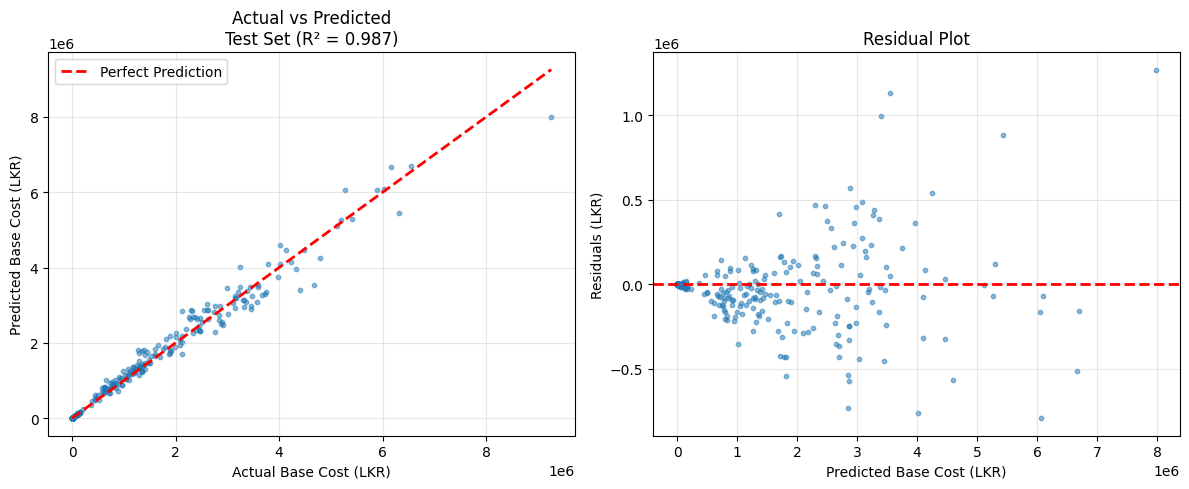

In [ ]:
# ----------------------------------------------------------
# 4.1 Final Test Evaluation
# ----------------------------------------------------------

if X_test is not None and y_test is not None:
    print("\n🧪 4.1 Final Test Evaluation")

    # Predict on test set (unseen data)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)   # RMSE manually
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-6))) * 100

    print(f"   Test RMSE:  LKR {test_rmse:,.0f}")
    print(f"   Test R²:    {test_r2:.4f}")
    print(f"   Test MAE:   LKR {test_mae:,.0f}")
    print(f"   Test MAPE:  {test_mape:.1f}%")

    # Visualize predictions vs actual
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, s=10)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Base Cost (LKR)')
    plt.ylabel('Predicted Base Cost (LKR)')
    plt.title(f'Actual vs Predicted\nTest Set (R² = {test_r2:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.5, s=10)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Base Cost (LKR)')
    plt.ylabel('Residuals (LKR)')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("\n🧪 4.1 Test Evaluation")
    print("   ⚠️ No test data available, using validation metrics")
    test_rmse = xgb_rmse
    test_r2 = xgb_r2
    test_mae = xgb_mae


In [ ]:
# ----------------------------------------------------------
# 4.2 Subgroup Analysis
# ----------------------------------------------------------

print("\n🔍 4.2 Subgroup Analysis")

# Add predictions to validation data for analysis
val_results = X_val.copy()
val_results['actual_cost'] = y_val.values
val_results['predicted_cost'] = y_val_pred_xgb

# Safely add subgroup columns using iloc (positional alignment)
val_results['boat_type'] = df_train.iloc[X_val.index]['boat_type'].values
val_results['monsoon_season'] = df_train.iloc[X_val.index]['monsoon_season'].values

# By boat type
print("\n   By Boat Type (Validation):")
for boat in val_results['boat_type'].unique():
    mask = val_results['boat_type'] == boat
    if mask.sum() > 10:
        rmse = np.sqrt(mean_squared_error(
            val_results.loc[mask, 'actual_cost'],
            val_results.loc[mask, 'predicted_cost']
        ))
        avg_cost = val_results.loc[mask, 'actual_cost'].mean()
        print(f"   {boat}: RMSE = LKR {rmse:,.0f} | Avg cost = LKR {avg_cost:,.0f} | Samples = {mask.sum()}")

# By monsoon season
print("\n   By Monsoon Season (Validation):")
for season in val_results['monsoon_season'].unique():
    mask = val_results['monsoon_season'] == season
    if mask.sum() > 10:
        rmse = np.sqrt(mean_squared_error(
            val_results.loc[mask, 'actual_cost'],
            val_results.loc[mask, 'predicted_cost']
        ))
        print(f"   {season}: RMSE = LKR {rmse:,.0f} | Samples = {mask.sum()}")



🔍 4.2 Subgroup Analysis

   By Boat Type (Validation):
   OFRP: RMSE = LKR 566 | Avg cost = LKR 10,950 | Samples = 224
   NTRB: RMSE = LKR 14 | Avg cost = LKR 625 | Samples = 117
   IMUL: RMSE = LKR 335,802 | Avg cost = LKR 2,311,800 | Samples = 46
   MTRB: RMSE = LKR 502 | Avg cost = LKR 8,398 | Samples = 18

   By Monsoon Season (Validation):
   southwest: RMSE = LKR 121,642 | Samples = 165
   inter: RMSE = LKR 107,922 | Samples = 112
   northeast: RMSE = LKR 101,897 | Samples = 139


In [ ]:
# ----------------------------------------------------------
# 4.3 FIXED Base Cost Predictor Class
# ----------------------------------------------------------

print("\n🔧 4.3 Creating Base Cost Predictor")

class BaseCostPredictor:
    """ML model for predicting base fishing trip costs"""

    def __init__(self, model, preprocessor, feature_names, categorical_cols):
        self.model = model
        self.preprocessor = preprocessor
        self.feature_names = feature_names
        self.categorical_cols = categorical_cols

        # Current prices (2025 Sri Lanka)
        self.current_prices = {
            'diesel': 277,      # LKR per liter
            'kerosene': 180,    # LKR per liter
            'ice': 25,          # LKR per kg
            'water': 50         # LKR per liter
        }

        # Boat configurations
        self.boat_configs = {
            'IMUL': {'crew_size': 12, 'ice_per_day': 150, 'class': 5},
            'IDAY': {'crew_size': 5, 'ice_per_day': 80, 'class': 4},
            'OFRP': {'crew_size': 3, 'ice_per_day': 40, 'class': 3},
            'MTRB': {'crew_size': 2, 'ice_per_day': 30, 'class': 2},
            'NTRB': {'crew_size': 1, 'ice_per_day': 10, 'class': 1},
            'NBSB': {'crew_size': 20, 'ice_per_day': 50, 'class': 1}
        }

    def preprocess_input(self, trip_data):
        """Prepare input data for prediction using the fitted preprocessor"""
        # Convert to DataFrame
        df = pd.DataFrame([trip_data])

        # Add derived features (same as training)
        df['trip_hours'] = df['trip_days'] * 24
        df['weather_impact'] = (df['wind_kph'] * df['wave_m']) / 10

        # Fuel efficiency (estimated)
        if 'engine_hp' in df.columns and 'trip_hours' in df.columns:
            df['fuel_efficiency'] = df['engine_hp'] * 0.1 / (df['trip_hours'] + 1e-6)
        else:
            df['fuel_efficiency'] = 0.1

        # Monsoon season
        month = trip_data.get('month', 6)
        if month in [5, 6, 7, 8, 9]:
            df['monsoon_season'] = 'southwest'
        elif month in [11, 12, 1, 2]:
            df['monsoon_season'] = 'northeast'
        else:
            df['monsoon_season'] = 'inter'

        # Boat type flags
        boat_type = trip_data.get('boat_type', 'OFRP')
        df['is_large_boat'] = 1 if boat_type in ['IMUL', 'IDAY'] else 0
        df['is_small_boat'] = 1 if boat_type in ['OFRP', 'MTRB'] else 0
        df['is_non_motorized'] = 1 if boat_type in ['NTRB', 'NBSB'] else 0

        # Port name (default to Negombo if not provided)
        if 'port_name' not in df.columns:
            df['port_name'] = 'Negombo'

        # Ensure all BASE_FEATURES are present
        for feature in BASE_FEATURES:
            if feature not in df.columns:
                df[feature] = 0  # Fill missing with 0

        # Reorder columns to match training
        df = df[BASE_FEATURES]

        # Transform using the fitted preprocessor
        X_processed = self.preprocessor.transform(df)

        return pd.DataFrame(X_processed, columns=self.feature_names)

    def predict_base_cost(self, trip_data):
        """Predict base cost with detailed breakdown"""
        try:
            # Prepare input
            X_input = self.preprocess_input(trip_data)

            # Predict total base cost
            base_cost_total = float(self.model.predict(X_input)[0])

            # Calculate component breakdown
            boat_type = trip_data.get('boat_type', 'OFRP')
            trip_days = trip_data.get('trip_days', 1)
            distance_km = trip_data.get('distance_km', 25)
            engine_hp = trip_data.get('engine_hp', 25)

            # 1. Fuel cost estimation
            fuel_liters = distance_km * 0.1 * self.boat_configs[boat_type]['class']
            fuel_liters += (trip_days * 24) * engine_hp * 0.0005

            if boat_type in ['IMUL', 'IDAY']:
                fuel_price = self.current_prices['diesel']
            elif boat_type in ['OFRP', 'MTRB']:
                fuel_price = self.current_prices['kerosene']
            else:
                fuel_price = 0

            fuel_cost = fuel_liters * fuel_price

            # 2. Ice cost estimation
            ice_kg = trip_days * self.boat_configs[boat_type]['ice_per_day']
            ice_cost = ice_kg * self.current_prices['ice']

            # 3. Water cost estimation
            water_liters = trip_days * self.boat_configs[boat_type]['crew_size'] * 5
            water_cost = water_liters * self.current_prices['water']

            # 4. Basic operations cost
            basic_ops_cost = fuel_cost * 0.15

            # Normalize to match predicted total
            components = {
                'fuel': fuel_cost,
                'ice': ice_cost,
                'water': water_cost,
                'basic_operations': basic_ops_cost
            }

            total_components = sum(components.values())

            if total_components > 0:
                scale_factor = base_cost_total / total_components
                for key in components:
                    components[key] = components[key] * scale_factor

            # Round values
            components_rounded = {k: round(v) for k, v in components.items()}

            # Confidence interval (±10%)
            confidence = base_cost_total * 0.1

            return {
                'success': True,
                'base_cost': round(base_cost_total),
                'components': components_rounded,
                'confidence': {
                    'range': f"LKR {round(base_cost_total - confidence):,} - LKR {round(base_cost_total + confidence):,}",
                    'margin': round(confidence),
                    'margin_percent': 10.0
                },
                'metadata': {
                    'boat_type': boat_type,
                    'trip_days': trip_days,
                    'distance_km': distance_km,
                    'engine_hp': engine_hp,
                    'model_used': 'XGBoost',
                    'version': '1.0'
                }
            }

        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'base_cost': None,
                'components': None,
                'confidence': None,
                'metadata': None
            }



🔧 4.3 Creating Base Cost Predictor


In [ ]:
# Create predictor with fixed preprocessing
predictor = BaseCostPredictor(best_model, preprocessor, feature_names, categorical_cols)
print("✅ Base cost predictor created (with fixed preprocessing)")


✅ Base cost predictor created (with fixed preprocessing)


In [ ]:
# ----------------------------------------------------------
# 4.4 Test Predictions with Example Data
# ----------------------------------------------------------

print("\n🧪 4.4 Test Predictions")

# Example 1: IMUL boat
print("\n📋 Example 1: IMUL (Multi-day tuna fishing)")
imul_trip = {
    'boat_type': 'IMUL',
    'engine_hp': 200,
    'trip_days': 14,
    'distance_km': 350,
    'wind_kph': 18,
    'wave_m': 1.4,
    'month': 6,
    'port_name': 'Negombo'
}


🧪 4.4 Test Predictions

📋 Example 1: IMUL (Multi-day tuna fishing)


In [ ]:
imul_result = predictor.predict_base_cost(imul_trip)
if imul_result['success']:
    print(f"   Total Base Cost: LKR {imul_result['base_cost']:,}")
    print(f"   Confidence: {imul_result['confidence']['range']}")
    print(f"   Breakdown:")
    for component, cost in imul_result['components'].items():
        print(f"   - {component:20s}: LKR {cost:>10,}")
else:
    print(f"   ❌ Error: {imul_result['error']}")

   Total Base Cost: LKR 1,029,059
   Confidence: LKR 926,153 - LKR 1,131,964
   Breakdown:
   - fuel                : LKR    369,440
   - ice                 : LKR    335,668
   - water               : LKR    268,534
   - basic_operations    : LKR     55,416


In [ ]:

# Example 2: OFRP boat
print("\n📋 Example 2: OFRP (Single-day lagoon fishing)")
ofrp_trip = {
    'boat_type': 'OFRP',
    'engine_hp': 25,
    'trip_days': 1,
    'distance_km': 25,
    'wind_kph': 12,
    'wave_m': 0.8,
    'month': 3,
    'port_name': 'Galle'
}


📋 Example 2: OFRP (Single-day lagoon fishing)


In [ ]:
ofrp_result = predictor.predict_base_cost(ofrp_trip)
if ofrp_result['success']:
    print(f"   Total Base Cost: LKR {ofrp_result['base_cost']:,}")
    print(f"   Confidence: {ofrp_result['confidence']['range']}")
    print(f"   Breakdown:")
    for component, cost in ofrp_result['components'].items():
        print(f"   - {component:20s}: LKR {cost:>10,}")
else:
    print(f"   ❌ Error: {ofrp_result['error']}")


   Total Base Cost: LKR 4,555
   Confidence: LKR 4,100 - LKR 5,011
   Breakdown:
   - fuel                : LKR      1,901
   - ice                 : LKR      1,354
   - water               : LKR      1,015
   - basic_operations    : LKR        285


In [ ]:
# Example 3: NTRB boat (non-motorized)
print("\n📋 Example 3: NTRB (Non-motorized row boat)")
ntrb_trip = {
    'boat_type': 'NTRB',
    'engine_hp': 0,
    'trip_days': 1,
    'distance_km': 5,
    'wind_kph': 8,
    'wave_m': 0.5,
    'month': 4,
    'port_name': 'Beruwala'
}


📋 Example 3: NTRB (Non-motorized row boat)


In [ ]:
ntrb_result = predictor.predict_base_cost(ntrb_trip)
if ntrb_result['success']:
    print(f"   Total Base Cost: LKR {ntrb_result['base_cost']:,}")
    print(f"   Confidence: {ntrb_result['confidence']['range']}")
    print(f"   Breakdown:")
    for component, cost in ntrb_result['components'].items():
        print(f"   - {component:20s}: LKR {cost:>10,}")
else:
    print(f"   ❌ Error: {ntrb_result['error']}")

   Total Base Cost: LKR 628
   Confidence: LKR 566 - LKR 691
   Breakdown:
   - fuel                : LKR          0
   - ice                 : LKR        314
   - water               : LKR        314
   - basic_operations    : LKR          0


In [ ]:
# ----------------------------------------------------------
# 4.5 Save Model for Deployment
# ----------------------------------------------------------

print("\n💾 4.5 Saving Model for Deployment")

# Create model directory in Google Drive
model_dir = f"{DATA_DIR}/fishing_base_cost_model"
os.makedirs(model_dir, exist_ok=True)

# Save all components
model_path = f"{model_dir}/base_cost_predictor.pkl"
joblib.dump(predictor, model_path)



💾 4.5 Saving Model for Deployment


['/content/drive/MyDrive/fisheries/fishing_base_cost_model/base_cost_predictor.pkl']

In [ ]:
# Save model configuration
config = {
    'features': BASE_FEATURES,
    'categorical_cols': categorical_cols,
    'feature_names': feature_names,
    'performance': {
        'test_rmse': float(test_rmse),
        'test_r2': float(test_r2),
        'test_mae': float(test_mae)
    },
    'prices': predictor.current_prices,
    'boat_configs': predictor.boat_configs,
    'version': '1.0',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'description': 'Base cost ML model for Sri Lanka fishing trips (Fuel + Ice + Water + Basic Ops)'
}


In [ ]:
config_path = f"{model_dir}/model_config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"✅ Model saved to Google Drive:")
print(f"   📁 Directory: {model_dir}")
print(f"   📄 Model file: base_cost_predictor.pkl")
print(f"   ⚙️  Config file: model_config.json")

✅ Model saved to Google Drive:
   📁 Directory: /content/drive/MyDrive/fisheries/fishing_base_cost_model
   📄 Model file: base_cost_predictor.pkl
   ⚙️  Config file: model_config.json


In [ ]:
# ----------------------------------------------------------
# 4.6 API Integration Example
# ----------------------------------------------------------

print("\n🌐 4.6 API Integration Example")

def predict_trip_cost_api(trip_data):
    """
    Example API function for your backend
    Input format:
    {
        "boat_type": "IMUL",
        "engine_hp": 200,
        "trip_days": 14,
        "distance_km": 350,
        "wind_kph": 18,
        "wave_m": 1.4,
        "month": 6,
        "port_name": "Negombo"
    }
    """
    try:
        # Use the predictor
        result = predictor.predict_base_cost(trip_data)

        # Format response
        response = {
            'success': result['success'],
            'prediction': {
                'base_cost_LKR': result['base_cost'],
                'confidence_range': result['confidence']['range'],
                'breakdown': result['components']
            },
            'metadata': result['metadata']
        }

        return response

    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'prediction': None
        }



🌐 4.6 API Integration Example


In [ ]:

# Test API function
print("\n   API function test:")
test_request = {
    "boat_type": "IMUL",
    "engine_hp": 200,
    "trip_days": 14,
    "distance_km": 350,
    "wind_kph": 18,
    "wave_m": 1.4,
    "month": 6,
    "port_name": "Negombo"
}



   API function test:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import json
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
# ----------------------------------------------------------
# 1.1 Load Training Data from Google Drive
# ----------------------------------------------------------

def load_training_data(data_dir):
    """Load all training CSV files from Google Drive"""
    print("📊 1.1 Loading training data from Google Drive...")

    # Find all training files
    train_files = glob.glob(f"{data_dir}/sri_lanka_fisheries_train_*.csv")

    if not train_files:
        raise FileNotFoundError(f"No training files found in {data_dir}")

    # Load training data
    train_dfs = []
    for file in train_files:
        df = pd.read_csv(file)
        train_dfs.append(df)
        print(f"   ✅ Loaded: {os.path.basename(file)} ({len(df)} rows)")

    df_train = pd.concat(train_dfs, ignore_index=True)

    # Load test data if available
    test_files = glob.glob(f"{data_dir}/sri_lanka_fisheries_test_*.csv")
    df_test = None
    if test_files:
        test_dfs = []
        for file in test_files:
            df = pd.read_csv(file)
            test_dfs.append(df)
            print(f"   ✅ Loaded: {os.path.basename(file)} ({len(df)} rows)")
        df_test = pd.concat(test_dfs, ignore_index=True)

    print(f"\n📊 DATA SUMMARY:")
    print(f"   Training data: {len(df_train):,} rows")
    if df_test is not None:
        print(f"   Test data:     {len(df_test):,} rows")

    return df_train, df_test

In [ ]:
# Load the data
df_train, df_test = load_training_data(DATA_DIR)


📊 1.1 Loading training data from Google Drive...
   ✅ Loaded: sri_lanka_fisheries_train_2022.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2023.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2024.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2025.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2022.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2023.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2024.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2025.csv (400 rows)

📊 DATA SUMMARY:
   Training data: 6,400 rows
   Test data:     1,600 rows


In [ ]:
# ----------------------------------------------------------
# 1.2 Data Cleaning
# ----------------------------------------------------------

print("\n🧹 1.2 Data Cleaning")

# Remove duplicates
original_shape = df_train.shape
df_train = df_train.drop_duplicates(subset=['trip_id'])
print(f"   ✅ Removed {original_shape[0] - df_train.shape[0]} duplicate trips")

# Handle missing values
missing_before = df_train.isnull().sum().sum()
df_train = df_train.fillna(method='ffill').fillna(method='bfill')
print(f"   ✅ Handled {missing_before - df_train.isnull().sum().sum()} missing values")

# Remove impossible values
original_len = len(df_train)
df_train = df_train[df_train['fuel_cost_LKR'] >= 0]
df_train = df_train[df_train['ice_cost_LKR'] >= 0]
df_train = df_train[df_train['crew_cost_LKR'] >= 0]
print(f"   ✅ Removed {original_len - len(df_train)} rows with negative costs")



🧹 1.2 Data Cleaning
   ✅ Removed 4321 duplicate trips
   ✅ Handled 0 missing values
   ✅ Removed 0 rows with negative costs


In [ ]:
# ----------------------------------------------------------
# 1.3 CORRECTED Feature Engineering (NO DATA LEAKAGE)
# ----------------------------------------------------------

print("\n🔧 1.3 Feature Engineering for Base Costs (No Leakage)")

# Boat configurations (available BEFORE trip)
boat_configs = {
    'IMUL': {'crew_size': 12, 'ice_per_day': 150, 'fuel_class': 5, 'is_large': 1, 'is_small': 0, 'is_non_motorized': 0},
    'IDAY': {'crew_size': 5, 'ice_per_day': 80, 'fuel_class': 4, 'is_large': 1, 'is_small': 0, 'is_non_motorized': 0},
    'OFRP': {'crew_size': 3, 'ice_per_day': 40, 'fuel_class': 3, 'is_large': 0, 'is_small': 1, 'is_non_motorized': 0},
    'MTRB': {'crew_size': 2, 'ice_per_day': 30, 'fuel_class': 2, 'is_large': 0, 'is_small': 1, 'is_non_motorized': 0},
    'NTRB': {'crew_size': 1, 'ice_per_day': 10, 'fuel_class': 1, 'is_large': 0, 'is_small': 0, 'is_non_motorized': 1},
    'NBSB': {'crew_size': 20, 'ice_per_day': 50, 'fuel_class': 1, 'is_large': 0, 'is_small': 0, 'is_non_motorized': 1}
}

# Create BASE COST TARGET using actual costs (for training only)
df_train['base_cost_LKR'] = (
    df_train['fuel_cost_LKR'] +
    df_train['ice_cost_LKR'] +
    df_train['crew_cost_LKR'] * 0.3 +  # 30% of crew cost is base (water + food)
    df_train['fuel_cost_LKR'] * 0.15   # Basic operations
)



🔧 1.3 Feature Engineering for Base Costs (No Leakage)


In [ ]:
# For test data (if available)
if df_test is not None:
    df_test['base_cost_LKR'] = (
        df_test['fuel_cost_LKR'] +
        df_test['ice_cost_LKR'] +
        df_test['crew_cost_LKR'] * 0.3 +
        df_test['fuel_cost_LKR'] * 0.15
    )

In [ ]:
# These are the ONLY features available before a trip starts
PRE_TRIP_FEATURES = [
    # Trip planning features
    'boat_type',           # What boat are you using?
    'engine_hp',           # Boat engine power
    'trip_days',           # How many days?
    'distance_km',         # How far?

    # Weather forecast (available before trip)
    'wind_kph',            # Wind forecast
    'wave_m',              # Wave height forecast

    # Temporal features
    'month',               # Seasonality
    'port_name',           # Departure port
]

In [ ]:
# Target variable
TARGET = 'base_cost_LKR'

print(f"✅ Creating pre-trip features only (no leakage):")
print(f"   Pre-trip features: {len(PRE_TRIP_FEATURES)} features")
print(f"   Target: {TARGET}")
print(f"   Training samples: {len(df_train):,}")
print(f"   Base cost range: LKR {df_train['base_cost_LKR'].min():,.0f} - LKR {df_train['base_cost_LKR'].max():,.0f}")

✅ Creating pre-trip features only (no leakage):
   Pre-trip features: 8 features
   Target: base_cost_LKR
   Training samples: 2,079
   Base cost range: LKR 1,575 - LKR 8,933,286


In [ ]:
# ==========================================================
# PHASE 2: PREPROCESSING PIPELINE (PRODUCTION READY)
# ==========================================================

print("\n" + "="*80)
print("PHASE 2: PREPROCESSING PIPELINE")
print("="*80)

# Prepare training data
X_train_full = df_train[PRE_TRIP_FEATURES].copy()
y_train_full = df_train[TARGET].copy()


PHASE 2: PREPROCESSING PIPELINE


In [ ]:
# Add derived features BEFORE splitting
print("🔧 Adding derived features...")

def add_derived_features_to_dataframe(df):
    """Add derived features that can be computed from pre-trip data"""
    df = df.copy()

    # Weather impact score (higher wind + waves = more fuel)
    df['weather_impact'] = (df['wind_kph'] * df['wave_m']) / 10

    # Trip hours
    df['trip_hours'] = df['trip_days'] * 24

    # Monsoon season (Sri Lanka specific)
    def get_monsoon(month):
        if month in [5, 6, 7, 8, 9]:
            return 'southwest'
        elif month in [11, 12, 1, 2]:
            return 'northeast'
        else:
            return 'inter'

    df['monsoon_season'] = df['month'].apply(get_monsoon)

    # Boat type flags (using pre-defined config)
    df['is_large_boat'] = df['boat_type'].map(lambda x: boat_configs.get(x, {}).get('is_large', 0))
    df['is_small_boat'] = df['boat_type'].map(lambda x: boat_configs.get(x, {}).get('is_small', 0))
    df['is_non_motorized'] = df['boat_type'].map(lambda x: boat_configs.get(x, {}).get('is_non_motorized', 0))

    return df

# Apply feature engineering
X_train_with_derived = add_derived_features_to_dataframe(X_train_full)

# Categorical columns
categorical_cols = ['boat_type', 'port_name', 'monsoon_season']


🔧 Adding derived features...


In [ ]:
# Numerical columns (will be standardized)
numerical_cols = ['engine_hp', 'trip_days', 'distance_km', 'wind_kph', 'wave_m', 'month',
                  'weather_impact', 'trip_hours', 'is_large_boat', 'is_small_boat', 'is_non_motorized']

print(f"\n📊 Feature Types:")
print(f"   Categorical ({len(categorical_cols)}): {categorical_cols}")
print(f"   Numerical ({len(numerical_cols)}): {numerical_cols[:5]}... + {len(numerical_cols)-5} more")

# ----------------------------------------------------------
# 2.1 Create Production Preprocessing Pipeline
# ----------------------------------------------------------

print("\n🔧 2.1 Creating Preprocessing Pipeline")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)


📊 Feature Types:
   Categorical (3): ['boat_type', 'port_name', 'monsoon_season']
   Numerical (11): ['engine_hp', 'trip_days', 'distance_km', 'wind_kph', 'wave_m']... + 6 more

🔧 2.1 Creating Preprocessing Pipeline


In [ ]:
def load_training_data(data_dir):
    """Load all training CSV files from Google Drive"""
    print("📊 1.1 Loading training data from Google Drive...")

    # Find all training files
    train_files = glob.glob(f"{data_dir}/sri_lanka_fisheries_train_*.csv")

    if not train_files:
        raise FileNotFoundError(f"No training files found in {data_dir}")

    # Load training data
    train_dfs = []
    for file in train_files:
        df = pd.read_csv(file)
        train_dfs.append(df)
        print(f"   ✅ Loaded: {os.path.basename(file)} ({len(df)} rows)")

    df_train = pd.concat(train_dfs, ignore_index=True)

    # Load test data if available
    test_files = glob.glob(f"{data_dir}/sri_lanka_fisheries_test_*.csv")
    df_test = None
    if test_files:
        test_dfs = []
        for file in test_files:
            df = pd.read_csv(file)
            test_dfs.append(df)
            print(f"   ✅ Loaded: {os.path.basename(file)} ({len(df)} rows)")
        df_test = pd.concat(test_dfs, ignore_index=True)

    print(f"\n📊 DATA SUMMARY:")
    print(f"   Training data: {len(df_train):,} rows")
    if df_test is not None:
        print(f"   Test data:     {len(df_test):,} rows")

    return df_train, df_test

# Load the data
df_train, df_test = load_training_data(DATA_DIR)

📊 1.1 Loading training data from Google Drive...
   ✅ Loaded: sri_lanka_fisheries_train_2022.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2023.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2024.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_train_2025.csv (1600 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2022.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2023.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2024.csv (400 rows)
   ✅ Loaded: sri_lanka_fisheries_test_2025.csv (400 rows)

📊 DATA SUMMARY:
   Training data: 6,400 rows
   Test data:     1,600 rows


In [ ]:
print("\n🧹 1.2 Data Cleaning")

# Remove duplicates
original_shape = df_train.shape
df_train = df_train.drop_duplicates(subset=['trip_id'])
print(f"   ✅ Removed {original_shape[0] - df_train.shape[0]} duplicate trips")

# Handle missing values
missing_before = df_train.isnull().sum().sum()
df_train = df_train.fillna(method='ffill').fillna(method='bfill')
print(f"   ✅ Handled {missing_before - df_train.isnull().sum().sum()} missing values")

# Remove impossible values
original_len = len(df_train)
df_train = df_train[df_train['fuel_cost_LKR'] >= 0]
df_train = df_train[df_train['ice_cost_LKR'] >= 0]
df_train = df_train[df_train['crew_cost_LKR'] >= 0]
print(f"   ✅ Removed {original_len - len(df_train)} rows with negative costs")


🧹 1.2 Data Cleaning
   ✅ Removed 4321 duplicate trips
   ✅ Handled 0 missing values
   ✅ Removed 0 rows with negative costs


In [ ]:

print("\n🔧 1.3 Creating Base Cost Target")

# Calculate base cost using actual historical data (for training only)
# This is what the model will learn to predict
df_train['base_cost_LKR'] = (
    df_train['fuel_cost_LKR'] +      # Fuel cost
    df_train['ice_cost_LKR'] +       # Ice cost
    df_train['crew_cost_LKR'] * 0.3  # 30% of crew cost for water/food
)

# Add basic operations cost (15% of fuel)
df_train['base_cost_LKR'] = df_train['base_cost_LKR'] + (df_train['fuel_cost_LKR'] * 0.15)

# For test data (if available)
if df_test is not None:
    df_test['base_cost_LKR'] = (
        df_test['fuel_cost_LKR'] +
        df_test['ice_cost_LKR'] +
        df_test['crew_cost_LKR'] * 0.3 +
        df_test['fuel_cost_LKR'] * 0.15
    )

print(f"✅ Base cost target created")
print(f"   Training samples: {len(df_train):,}")
print(f"   Base cost range: LKR {df_train['base_cost_LKR'].min():,.0f} - LKR {df_train['base_cost_LKR'].max():,.0f}")
print(f"   Average base cost: LKR {df_train['base_cost_LKR'].mean():,.0f}")

# ==========================================================
# PHASE 2: FEATURE ENGINEERING (PRE-TRIP FEATURES ONLY)
# ==========================================================

print("\n" + "="*80)
print("PHASE 2: FEATURE ENGINEERING")
print("="*80)

# Boat configurations (available BEFORE trip)
boat_configs = {
    'IMUL': {'crew_size': 12, 'ice_per_day': 150, 'fuel_class': 5},
    'IDAY': {'crew_size': 5, 'ice_per_day': 80, 'fuel_class': 4},
    'OFRP': {'crew_size': 3, 'ice_per_day': 40, 'fuel_class': 3},
    'MTRB': {'crew_size': 2, 'ice_per_day': 30, 'fuel_class': 2},
    'NTRB': {'crew_size': 1, 'ice_per_day': 10, 'fuel_class': 1},
    'NBSB': {'crew_size': 20, 'ice_per_day': 50, 'fuel_class': 1}
}


🔧 1.3 Creating Base Cost Target
✅ Base cost target created
   Training samples: 2,079
   Base cost range: LKR 1,575 - LKR 8,933,286
   Average base cost: LKR 280,890

PHASE 2: FEATURE ENGINEERING


In [ ]:
# Features available BEFORE trip starts
PRE_TRIP_FEATURES = [
    # Boat characteristics
    'boat_type',     # What boat are you using?
    'engine_hp',     # Boat engine power

    # Trip planning
    'trip_days',     # How many days?
    'distance_km',   # How far?

    # Weather forecast (available before trip)
    'wind_kph',      # Wind forecast
    'wave_m',        # Wave height forecast

    # Temporal features
    'month',         # Which month? (seasonality)
    'port_name',     # Departure port
]

# Target variable
TARGET = 'base_cost_LKR'

print("✅ Using ONLY pre-trip features (no data leakage):")
print(f"   Features: {len(PRE_TRIP_FEATURES)}")
print(f"   Target: {TARGET}")
print("\n📋 Feature details:")
for i, feature in enumerate(PRE_TRIP_FEATURES, 1):
    print(f"   {i:2d}. {feature:15s} - Available before trip ✓")

# ----------------------------------------------------------
# 2.1 Prepare Training Data
# ----------------------------------------------------------

print("\n🔧 2.1 Preparing training data with derived features")

def create_derived_features(df):
    """Create derived features from pre-trip data"""
    df = df.copy()

    # Weather impact score
    df['weather_impact'] = (df['wind_kph'] * df['wave_m']) / 10

    # Trip hours (for fuel estimation)
    df['trip_hours'] = df['trip_days'] * 24

    # Monsoon season (Sri Lanka specific)
    def get_monsoon_season(month):
        if month in [5, 6, 7, 8, 9]:
            return 'southwest'
        elif month in [11, 12, 1, 2]:
            return 'northeast'
        else:
            return 'inter'

    df['monsoon_season'] = df['month'].apply(get_monsoon_season)

    # Boat type flags
    df['is_large_boat'] = df['boat_type'].isin(['IMUL', 'IDAY']).astype(int)
    df['is_small_boat'] = df['boat_type'].isin(['OFRP', 'MTRB']).astype(int)
    df['is_non_motorized'] = df['boat_type'].isin(['NTRB', 'NBSB']).astype(int)

    return df

# Prepare training data
X_train_raw = df_train[PRE_TRIP_FEATURES].copy()
y_train = df_train[TARGET].copy()

# Add derived features
X_train = create_derived_features(X_train_raw)

print(f"✅ Training data prepared:")
print(f"   Samples: {X_train.shape[0]:,}")
print(f"   Features before encoding: {X_train.shape[1]}")

# ----------------------------------------------------------
# 2.2 Create Preprocessing Pipeline
# ----------------------------------------------------------

print("\n🔧 2.2 Creating preprocessing pipeline")

# Identify column types
categorical_cols = ['boat_type', 'port_name', 'monsoon_season']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

print(f"   Categorical columns: {categorical_cols}")
print(f"   Numerical columns: {len(numerical_cols)} features")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)



✅ Using ONLY pre-trip features (no data leakage):
   Features: 8
   Target: base_cost_LKR

📋 Feature details:
    1. boat_type       - Available before trip ✓
    2. engine_hp       - Available before trip ✓
    3. trip_days       - Available before trip ✓
    4. distance_km     - Available before trip ✓
    5. wind_kph        - Available before trip ✓
    6. wave_m          - Available before trip ✓
    7. month           - Available before trip ✓
    8. port_name       - Available before trip ✓

🔧 2.1 Preparing training data with derived features
✅ Training data prepared:
   Samples: 2,079
   Features before encoding: 14

🔧 2.2 Creating preprocessing pipeline
   Categorical columns: ['boat_type', 'port_name', 'monsoon_season']
   Numerical columns: 11 features


In [ ]:
# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)

# Get feature names after encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_feature_names = list(cat_features) + numerical_cols

print(f"✅ Preprocessor created:")
print(f"   Total features after encoding: {len(all_feature_names)}")
print(f"   Categorical features: {len(cat_features)}")
print(f"   Numerical features: {len(numerical_cols)}")

# ----------------------------------------------------------
# 2.3 Data Splitting
# ----------------------------------------------------------

✅ Preprocessor created:
   Total features after encoding: 25
   Categorical features: 14
   Numerical features: 11


In [ ]:
print("\n📊 2.3 Data splitting")

# Create cost bins for stratification
df_train['cost_bin'] = pd.cut(df_train['base_cost_LKR'], bins=5, labels=False)

# Train (80%) / Validation (20%) split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_processed, y_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['cost_bin']
)

# Remove temporary column
df_train = df_train.drop(columns=['cost_bin'])

print(f"✅ Split complete:")
print(f"   Training set:   {X_train_split.shape[0]:,} samples")
print(f"   Validation set: {X_val.shape[0]:,} samples")



📊 2.3 Data splitting
✅ Split complete:
   Training set:   1,663 samples
   Validation set: 416 samples


In [ ]:

if df_test is not None:
    print(f"\n📊 2.4 Preparing test data...")
    X_test_raw = df_test[PRE_TRIP_FEATURES].copy()
    y_test = df_test[TARGET].copy()

    # Add derived features
    X_test = create_derived_features(X_test_raw)

    # Transform using fitted preprocessor
    X_test_processed = preprocessor.transform(X_test)

    print(f"   Test set: {X_test_processed.shape[0]:,} samples")
else:
    X_test_processed, y_test = None, None
    print(f"   Test set: Not available")


📊 2.4 Preparing test data...
   Test set: 1,600 samples


In [ ]:
# ==========================================================
# PHASE 3: MODEL TRAINING & EVALUATION
# ==========================================================

print("\n" + "="*80)
print("PHASE 3: MODEL TRAINING")
print("="*80)


PHASE 3: MODEL TRAINING


In [ ]:
# ----------------------------------------------------------
# 3.1 Train Multiple Models
# ----------------------------------------------------------

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

In [ ]:
# ----------------------------------------------------------
# 3.1 Train Multiple Models (Version-Safe & Research-Ready)
# ----------------------------------------------------------

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

models = {
    'Linear Regression': LinearRegression(),

    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

results = {}

for name, model in models.items():
    print(f"\n🎯 Training {name}...")

    # -----------------------------
    # Train model
    # -----------------------------
    model.fit(X_train_split, y_train_split)

    # -----------------------------
    # Predict on validation set
    # -----------------------------
    y_val_pred = model.predict(X_val)

    # -----------------------------
    # Evaluation metrics (SAFE)
    # -----------------------------
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)                     # RMSE (version-safe)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)

    # Stable MAPE (handles near-zero Sri Lankan cost values)
    mape = np.mean(
        np.abs(y_val - y_val_pred) / np.maximum(np.abs(y_val), 1)
    ) * 100

    # -----------------------------
    # Store results
    # -----------------------------
    results[name] = {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'mape': mape
    }

    # -----------------------------
    # Print metrics
    # -----------------------------
    print(f"   Validation RMSE:  LKR {rmse:,.0f}")
    print(f"   Validation R²:    {r2:.4f}")
    print(f"   Validation MAE:   LKR {mae:,.0f}")
    print(f"   Validation MAPE:  {mape:.1f}%")



🎯 Training Linear Regression...
   Validation RMSE:  LKR 357,597
   Validation R²:    0.8612
   Validation MAE:   LKR 164,794
   Validation MAPE:  1509.6%

🎯 Training Random Forest...
   Validation RMSE:  LKR 255,444
   Validation R²:    0.9292
   Validation MAE:   LKR 74,380
   Validation MAPE:  15.5%

🎯 Training XGBoost...
   Validation RMSE:  LKR 251,083
   Validation R²:    0.9316
   Validation MAE:   LKR 71,602
   Validation MAPE:  21.6%


In [ ]:

# ----------------------------------------------------------
# 3.2 Model Comparison
# ----------------------------------------------------------

print("\n📊 3.2 Model Comparison")
print(f"{'Model':<20} {'RMSE (LKR)':<15} {'R²':<10} {'MAPE':<10}")
print("-" * 60)

for name, metrics in results.items():
    print(f"{name:<20} {metrics['rmse']:<15,.0f} {metrics['r2']:<10.4f} {metrics['mape']:<10.1f}%")

# Select best model
best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print(f"\n✅ Selected best model: {best_model_name}")
print(f"   R²: {best_metrics['r2']:.4f}")
print(f"   RMSE: LKR {best_metrics['rmse']:,.0f}")
print(f"   MAPE: {best_metrics['mape']:.1f}%")


📊 3.2 Model Comparison
Model                RMSE (LKR)      R²         MAPE      
------------------------------------------------------------
Linear Regression    357,597         0.8612     1509.6    %
Random Forest        255,444         0.9292     15.5      %
XGBoost              251,083         0.9316     21.6      %

✅ Selected best model: XGBoost
   R²: 0.9316
   RMSE: LKR 251,083
   MAPE: 21.6%



🧪 3.3 Test Evaluation
   Test RMSE:  LKR 332,739
   Test R²:    0.8636
   Test MAE:   LKR 88,385
   Test MAPE:  23.8%


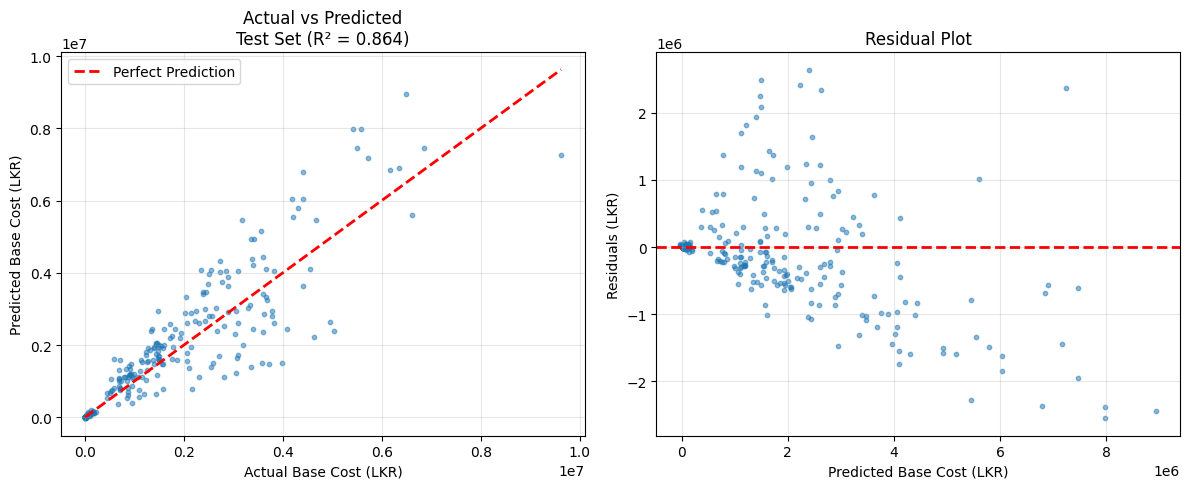


🔍 3.4 Feature Importance Analysis


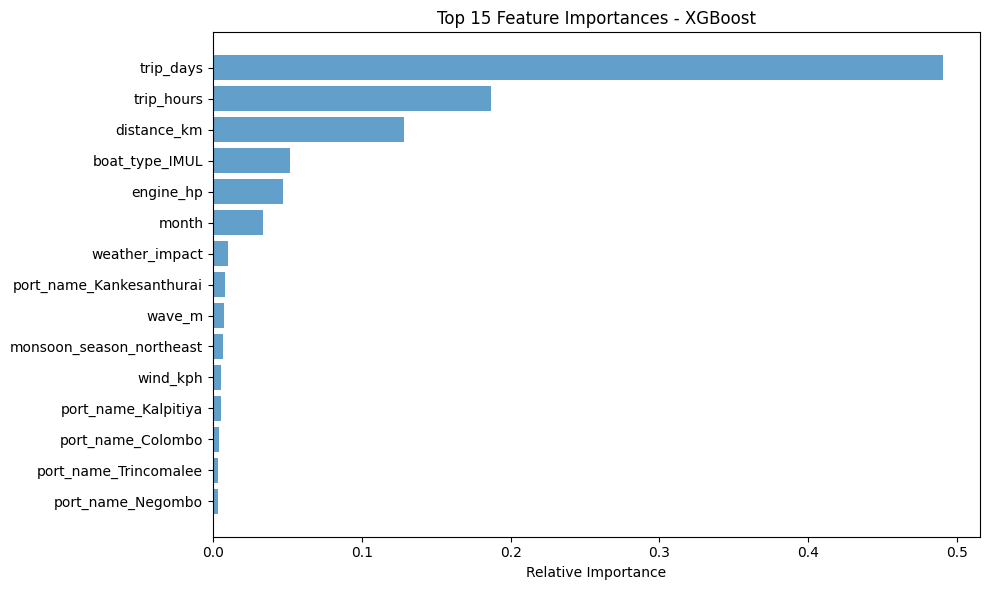

Top 10 Most Important Features:
 1. trip_days                               : 0.4909
 2. trip_hours                              : 0.1868
 3. distance_km                             : 0.1282
 4. boat_type_IMUL                          : 0.0514
 5. engine_hp                               : 0.0470
 6. month                                   : 0.0333
 7. weather_impact                          : 0.0102
 8. port_name_Kankesanthurai                : 0.0079
 9. wave_m                                  : 0.0071
10. monsoon_season_northeast                : 0.0070


In [ ]:
# ----------------------------------------------------------
# 3.3 Test Evaluation (Version-Safe)
# ----------------------------------------------------------

if X_test_processed is not None and y_test is not None:
    print("\n🧪 3.3 Test Evaluation")

    # Predict on test set
    y_test_pred = best_model.predict(X_test_processed)

    # -----------------------------
    # Metrics (SAFE IMPLEMENTATION)
    # -----------------------------
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)          # RMSE without squared=
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Stable MAPE (prevents divide-by-zero)
    test_mape = np.mean(
        np.abs(y_test - y_test_pred) / np.maximum(np.abs(y_test), 1)
    ) * 100

    print(f"   Test RMSE:  LKR {test_rmse:,.0f}")
    print(f"   Test R²:    {test_r2:.4f}")
    print(f"   Test MAE:   LKR {test_mae:,.0f}")
    print(f"   Test MAPE:  {test_mape:.1f}%")

    # -----------------------------
    # Visualization
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Actual vs Predicted
    axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
    axes[0].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Perfect Prediction'
    )
    axes[0].set_xlabel('Actual Base Cost (LKR)')
    axes[0].set_ylabel('Predicted Base Cost (LKR)')
    axes[0].set_title(f'Actual vs Predicted\nTest Set (R² = {test_r2:.3f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Residual plot
    residuals = y_test - y_test_pred
    axes[1].scatter(y_test_pred, residuals, alpha=0.5, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Base Cost (LKR)')
    axes[1].set_ylabel('Residuals (LKR)')
    axes[1].set_title('Residual Plot')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("\n🧪 3.3 Test Evaluation")
    print("   ⚠️ No test data available, using validation metrics")

    test_rmse = best_metrics['rmse']
    test_r2 = best_metrics['r2']
    test_mae = best_metrics['mae']
    test_mape = best_metrics['mape']


# ----------------------------------------------------------
# 3.4 Feature Importance (Random Forest / XGBoost)
# ----------------------------------------------------------

if best_model_name in ['Random Forest', 'XGBoost']:
    print("\n🔍 3.4 Feature Importance Analysis")

    importances = best_model.feature_importances_

    # Top 15 features
    indices = np.argsort(importances)[-15:]

    plt.figure(figsize=(10, 6))
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.barh(range(len(indices)), importances[indices], alpha=0.7)
    plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

    # Print Top 10 (Readable)
    print("Top 10 Most Important Features:")
    sorted_indices = np.argsort(importances)[::-1][:10]

    for i, idx in enumerate(sorted_indices, 1):
        feat_name = all_feature_names[idx]
        if len(feat_name) > 40:
            feat_name = feat_name[:37] + "..."
        print(f"{i:2d}. {feat_name:40s}: {importances[idx]:.4f}")


In [ ]:
# ==========================================================
# PHASE 4: PRODUCTION PREDICTOR
# ==========================================================

print("\n" + "="*80)
print("PHASE 4: PRODUCTION PREDICTOR")
print("="*80)

# ----------------------------------------------------------
# 4.1 Production Predictor Class
# ----------------------------------------------------------

class FishingCostPredictor:
    """Production-ready predictor for fishing trip costs"""

    def __init__(self, model, preprocessor, feature_names, categorical_cols):
        self.model = model
        self.preprocessor = preprocessor
        self.feature_names = feature_names
        self.categorical_cols = categorical_cols

        # Current prices (2025 Sri Lanka)
        self.current_prices = {
            'diesel': 277,      # LKR per liter
            'kerosene': 180,    # LKR per liter
            'ice': 25,          # LKR per kg
            'water': 50         # LKR per liter
        }

        # Boat configurations
        self.boat_configs = boat_configs

        # Model metadata
        self.metadata = {
            'model_name': best_model_name,
            'version': '1.0',
            'training_date': datetime.now().strftime('%Y-%m-%d'),
            'performance': {
                'r2': float(test_r2),
                'rmse': float(test_rmse),
                'mape': float(test_mape)
            }
        }

    def prepare_input(self, trip_data):
        """Prepare input for prediction"""
        # Convert to DataFrame
        df = pd.DataFrame([trip_data])

        # Ensure all pre-trip features are present
        for feature in PRE_TRIP_FEATURES:
            if feature not in df.columns:
                # Set defaults
                defaults = {
                    'boat_type': 'OFRP',
                    'engine_hp': 25,
                    'trip_days': 1,
                    'distance_km': 25,
                    'wind_kph': 12,
                    'wave_m': 0.8,
                    'month': datetime.now().month,
                    'port_name': 'Negombo'
                }
                df[feature] = defaults.get(feature, 0)

        # Create derived features
        df = create_derived_features(df)

        return df

    def predict(self, trip_data):
        """Main prediction method"""
        try:
            # Prepare input
            X_input = self.prepare_input(trip_data)

            # Preprocess
            X_processed = self.preprocessor.transform(X_input)

            # Predict
            base_cost_pred = float(self.model.predict(X_processed)[0])

            # Ensure positive
            base_cost_pred = max(0, base_cost_pred)

            # Generate breakdown
            breakdown = self._generate_breakdown(trip_data, base_cost_pred)

            # Confidence interval
            margin = 0.15  # 15% margin
            confidence = base_cost_pred * margin

            return {
                'success': True,
                'prediction': {
                    'base_cost_lkr': round(base_cost_pred),
                    'breakdown': breakdown,
                    'confidence': {
                        'margin_percent': 15.0,
                        'lower_bound': round(base_cost_pred - confidence),
                        'upper_bound': round(base_cost_pred + confidence),
                        'range': f"LKR {round(base_cost_pred - confidence):,} - LKR {round(base_cost_pred + confidence):,}"
                    }
                },
                'metadata': {
                    'boat_type': trip_data.get('boat_type', 'OFRP'),
                    'model': self.metadata['model_name'],
                    'version': self.metadata['version'],
                    'timestamp': datetime.now().isoformat()
                }
            }

        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'prediction': None
            }

    def _generate_breakdown(self, trip_data, total_cost):
        """Generate cost breakdown"""
        boat_type = trip_data.get('boat_type', 'OFRP')
        config = self.boat_configs.get(boat_type, self.boat_configs['OFRP'])

        trip_days = trip_data.get('trip_days', 1)
        distance_km = trip_data.get('distance_km', 25)
        engine_hp = trip_data.get('engine_hp', 25)

        # Fuel estimation
        if boat_type in ['IMUL', 'IDAY']:
            fuel_price = self.current_prices['diesel']
        elif boat_type in ['OFRP', 'MTRB']:
            fuel_price = self.current_prices['kerosene']
        else:
            fuel_price = 0

        fuel_liters = distance_km * 0.1 * config['fuel_class']
        fuel_liters += trip_days * 24 * engine_hp * 0.0005
        fuel_cost = fuel_liters * fuel_price

        # Ice cost
        ice_kg = trip_days * config['ice_per_day']
        ice_cost = ice_kg * self.current_prices['ice']

        # Water cost
        water_liters = trip_days * config['crew_size'] * 5
        water_cost = water_liters * self.current_prices['water']

        # Basic operations
        basic_ops_cost = fuel_cost * 0.15

        # Scale to match predicted total
        components_total = fuel_cost + ice_cost + water_cost + basic_ops_cost

        if components_total > 0:
            scale = total_cost / components_total
            fuel_cost *= scale
            ice_cost *= scale
            water_cost *= scale
            basic_ops_cost *= scale

        return {
            'fuel': round(fuel_cost),
            'ice': round(ice_cost),
            'water': round(water_cost),
            'basic_operations': round(basic_ops_cost)
        }



PHASE 4: PRODUCTION PREDICTOR


In [ ]:
# Create predictor
print("🔧 Creating production predictor...")
predictor = FishingCostPredictor(best_model, preprocessor, all_feature_names, categorical_cols)
print("✅ Production predictor created")

# ----------------------------------------------------------
# 4.2 Test Predictions
# ----------------------------------------------------------

print("\n🧪 4.2 Test Predictions")

examples = [
    {
        'name': 'IMUL (Multi-day tuna fishing)',
        'data': {
            'boat_type': 'IMUL',
            'engine_hp': 200,
            'trip_days': 14,
            'distance_km': 350,
            'wind_kph': 18,
            'wave_m': 1.4,
            'month': 6,
            'port_name': 'Negombo'
        }
    },
    {
        'name': 'OFRP (Single-day fishing)',
        'data': {
            'boat_type': 'OFRP',
            'engine_hp': 25,
            'trip_days': 1,
            'distance_km': 25,
            'wind_kph': 12,
            'wave_m': 0.8,
            'month': 3,
            'port_name': 'Galle'
        }
    }
]

🔧 Creating production predictor...
✅ Production predictor created

🧪 4.2 Test Predictions


In [ ]:

for example in examples:
    print(f"\n📋 {example['name']}")
    result = predictor.predict(example['data'])

    if result['success']:
        pred = result['prediction']
        print(f"   ✅ Base Cost: LKR {pred['base_cost_lkr']:,}")
        print(f"   📊 Confidence: {pred['confidence']['range']}")
        print(f"   📈 Breakdown:")
        for component, cost in pred['breakdown'].items():
            print(f"     - {component.replace('_', ' ').title():20s}: LKR {cost:>10,}")
    else:
        print(f"   ❌ Error: {result['error']}")

# ----------------------------------------------------------
# 4.3 Save Model for Deployment
# ----------------------------------------------------------

print("\n💾 4.3 Saving Model for Deployment")

# Create model directory
model_dir = f"{DATA_DIR}/fishing_cost_model"
os.makedirs(model_dir, exist_ok=True)

# Save predictor
predictor_path = f"{model_dir}/fishing_cost_predictor.pkl"
joblib.dump(predictor, predictor_path)


📋 IMUL (Multi-day tuna fishing)
   ✅ Base Cost: LKR 2,015,012
   📊 Confidence: LKR 1,712,760 - LKR 2,317,264
   📈 Breakdown:
     - Fuel                : LKR    723,406
     - Ice                 : LKR    657,275
     - Water               : LKR    525,820
     - Basic Operations    : LKR    108,511

📋 OFRP (Single-day fishing)
   ✅ Base Cost: LKR 10,165
   📊 Confidence: LKR 8,640 - LKR 11,690
   📈 Breakdown:
     - Fuel                : LKR      4,242
     - Ice                 : LKR      3,021
     - Water               : LKR      2,266
     - Basic Operations    : LKR        636

💾 4.3 Saving Model for Deployment


['/content/drive/MyDrive/fisheries/fishing_cost_model/fishing_cost_predictor.pkl']

In [ ]:
# Save configuration
config = {
    'model_type': best_model_name,
    'pre_trip_features': PRE_TRIP_FEATURES,
    'target': TARGET,
    'categorical_features': categorical_cols,
    'feature_names': all_feature_names,
    'performance': {
        'r2': float(test_r2),
        'rmse': float(test_rmse),
        'mape': float(test_mape)
    },
    'boat_configs': boat_configs,
    'current_prices': predictor.current_prices,
    'version': '1.0',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

In [ ]:

config_path = f"{model_dir}/model_config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"✅ Model saved:")
print(f"   📁 Directory: {model_dir}")
print(f"   📄 Predictor: fishing_cost_predictor.pkl")
print(f"   ⚙️  Config: model_config.json")

✅ Model saved:
   📁 Directory: /content/drive/MyDrive/fisheries/fishing_cost_model
   📄 Predictor: fishing_cost_predictor.pkl
   ⚙️  Config: model_config.json
